In [35]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt

# This command ensures plots appear inside the notebook
%matplotlib inline

# --- LOAD DATA STEP ---
# 1. Open the Hubble f105w fits image using Astropy
hdu_list = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

# 2. Extract the actual image data from the file
data = hdu_list[0].data

# 3. Cast the data to standard floats.
data = data.astype(float)

# 4. Close the file to free up memory
hdu_list.close()

# 5. Verify it worked
print("Success! Data loaded. Image shape:", data.shape)

Success! Data loaded. Image shape: (3600, 3600)


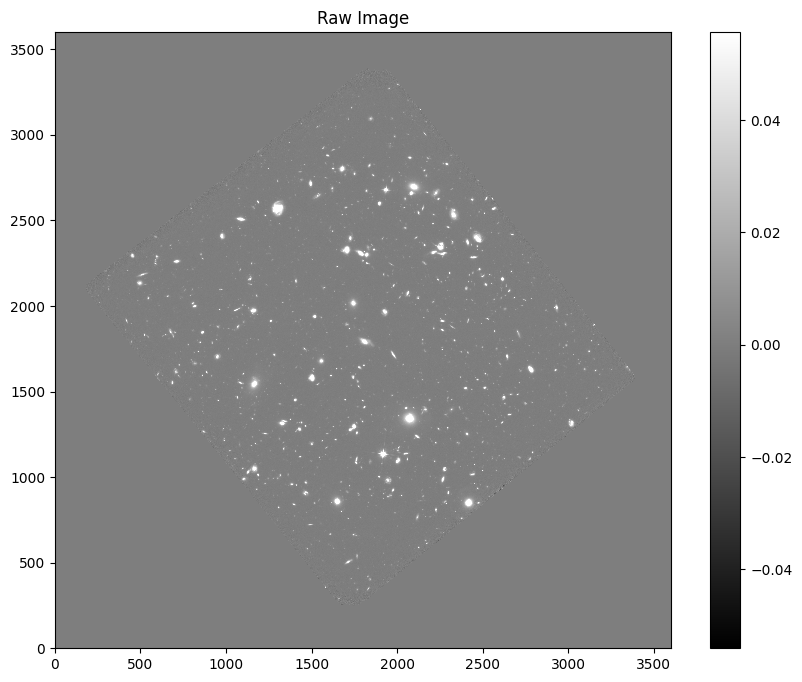

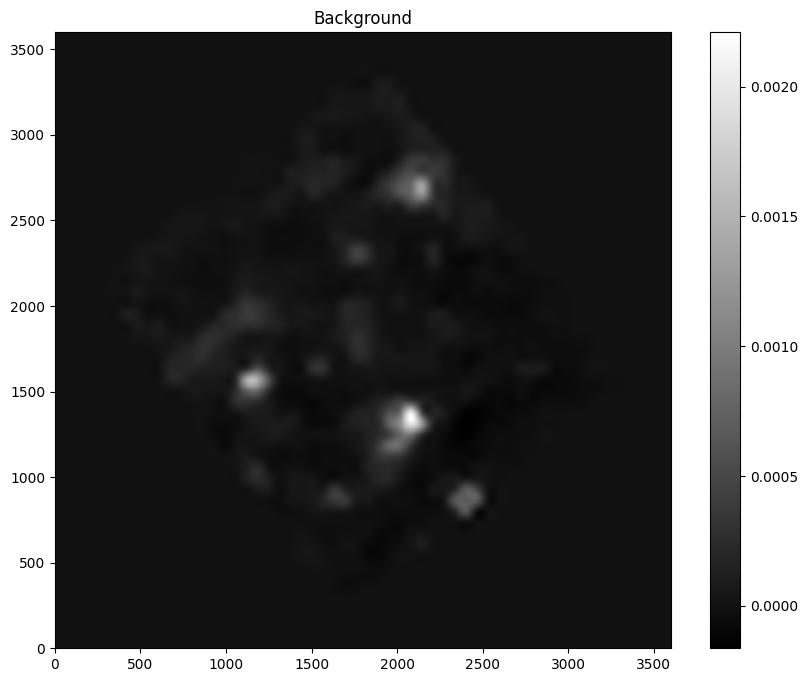

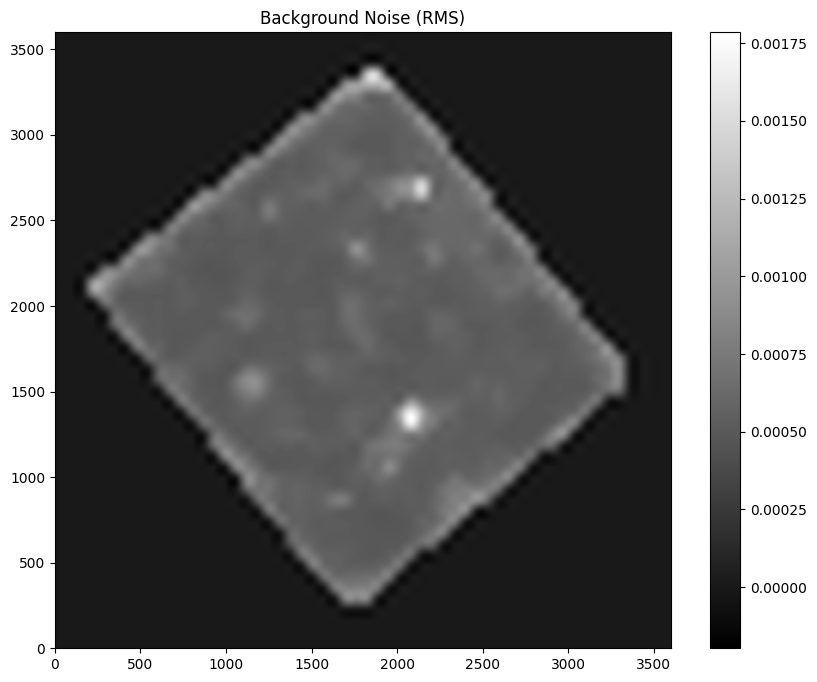

In [36]:
# --- STEP 1: VISUALIZE RAW DATA ---
# Calculate mean and standard deviation to scale the image brightness automatically
m, s = np.mean(data), np.std(data)

# Create the plot
plt.figure(figsize=(10, 8))
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title("Raw Image")

# INSTRUCTION STEP 4: Save the figure as png
plt.savefig("UDF_1_raw.png")
plt.show() # Show it in the notebook too

# --- STEP 2: BACKGROUND SUBTRACTION ---
# Measure a spatially varying background on the image
bkg = sep.Background(data)

# VISUALIZE THE BACKGROUND (What the code thinks is "empty space")
plt.figure(figsize=(10, 8))
plt.imshow(bkg.back(), interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background")
plt.savefig("UDF_2_background.png") # Save 2nd fig as png
plt.show()

# VISUALIZE THE NOISE (The static/fuzziness of the background)
plt.figure(figsize=(10, 8))
plt.imshow(bkg.rms(), interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background Noise (RMS)")
plt.savefig("UDF_3_noise.png") # Save 3d fig as png
plt.show()

# --- STEP 3: SUBTRACT BACKGROUND ---
# We subtract the background so we are only looking at the actual stars/galaxies
data_sub = data - bkg

Detected 8640 objects in the image.


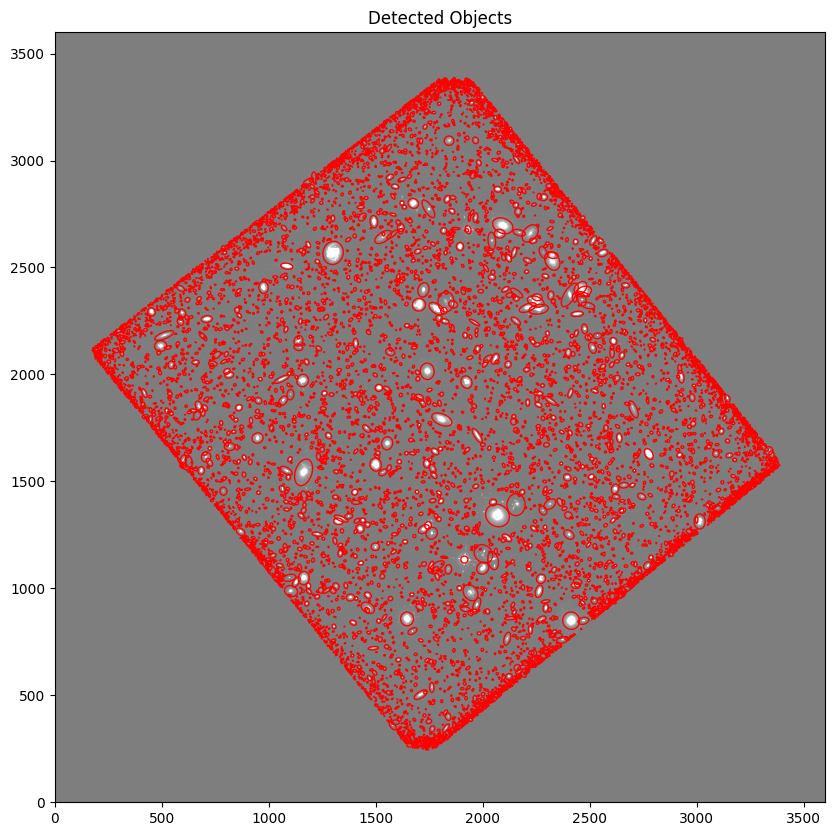

In [37]:
from matplotlib.patches import Ellipse

# --- STEP 4: DETECT OBJECTS ---
# 'thresh=1.5' means we look for pixels that are 1.5 times brighter than the background noise.
# This acts like a sensitivity dial: Lower = more false detections, Higher = misses faint stars.
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

print(f"Detected {len(objects)} objects in the image.")  # INSTRUCTION STEP 6: HOW MANY SOURCES FOUND

# --- STEP 5: VISUALIZE DETECTIONS ---
# Plot the background-subtracted image
fig, ax = plt.subplots(figsize=(10, 10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# Loop through each detected object and draw a red ellipse around it
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_patch(e)

ax.set_title("Detected Objects")

# INSTRUCTION STEP 4: Save the 4th figure
plt.savefig("UDF_4_objects.png")
plt.show()

Mean Flux: 1.17
Median Flux: 0.03
Standard Deviation: 17.55

Largest Outlier Flux: 1218.40
Location of Outlier (x, y): (1914.25, 1134.32)
Distance from Mean: 69.37 standard deviations


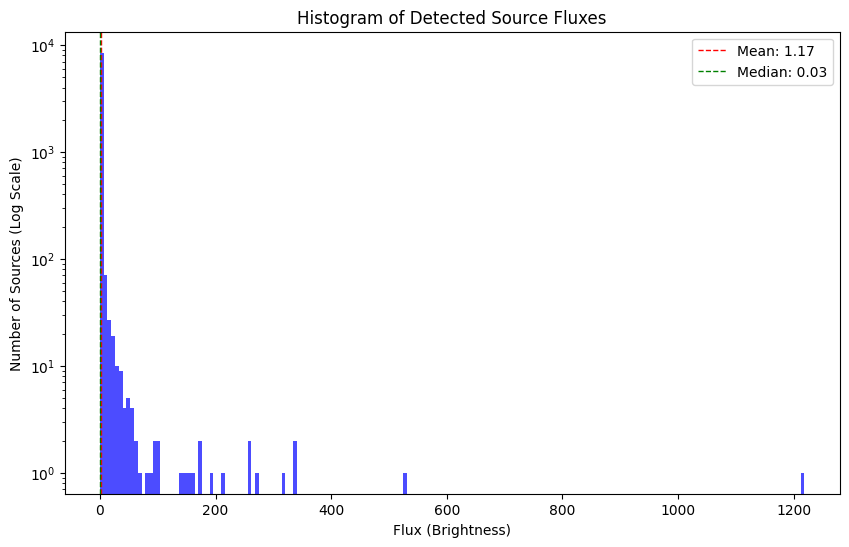

In [38]:
# --- STEP 6 & 7: FLUX STATISTICS & HISTOGRAM ---

# 1. Extract the "flux" (brightness) from the objects list
fluxes = objects['flux']

# 2. Calculate mean, median, and standard deviation
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)

print(f"Mean Flux: {mean_flux:.2f}")
print(f"Median Flux: {median_flux:.2f}")
print(f"Standard Deviation: {std_flux:.2f}")

# 3. Find the "Largest Outlier" (The brightest object)
max_flux = np.max(fluxes)
max_index = np.argmax(fluxes) # Which object number is it?

# Grab x and y of Largest Outlier
x_pos = objects['x'][max_index]
y_pos = objects['y'][max_index]

# Calculate how many standard deviations away it is (Z-score)
sigma_distance = (max_flux - mean_flux) / std_flux

print(f"\nLargest Outlier Flux: {max_flux:.2f}")
print(f"Location of Outlier (x, y): ({x_pos:.2f}, {y_pos:.2f})")
print(f"Distance from Mean: {sigma_distance:.2f} standard deviations")

# 4. Create the Histogram
plt.figure(figsize=(10, 6))

# We use a logarithmic scale (log=True) because there are MANY faint things and few bright things.
plt.hist(fluxes, bins='auto', color='blue', alpha=0.7, log=True)

plt.axvline(mean_flux, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_flux:.2f}')
plt.axvline(median_flux, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_flux:.2f}')

plt.xlabel("Flux (Brightness)")
plt.ylabel("Number of Sources (Log Scale)")
plt.title("Histogram of Detected Source Fluxes")
plt.legend()
plt.savefig("histogram_fluxes.png") # Save for rubric
plt.show()

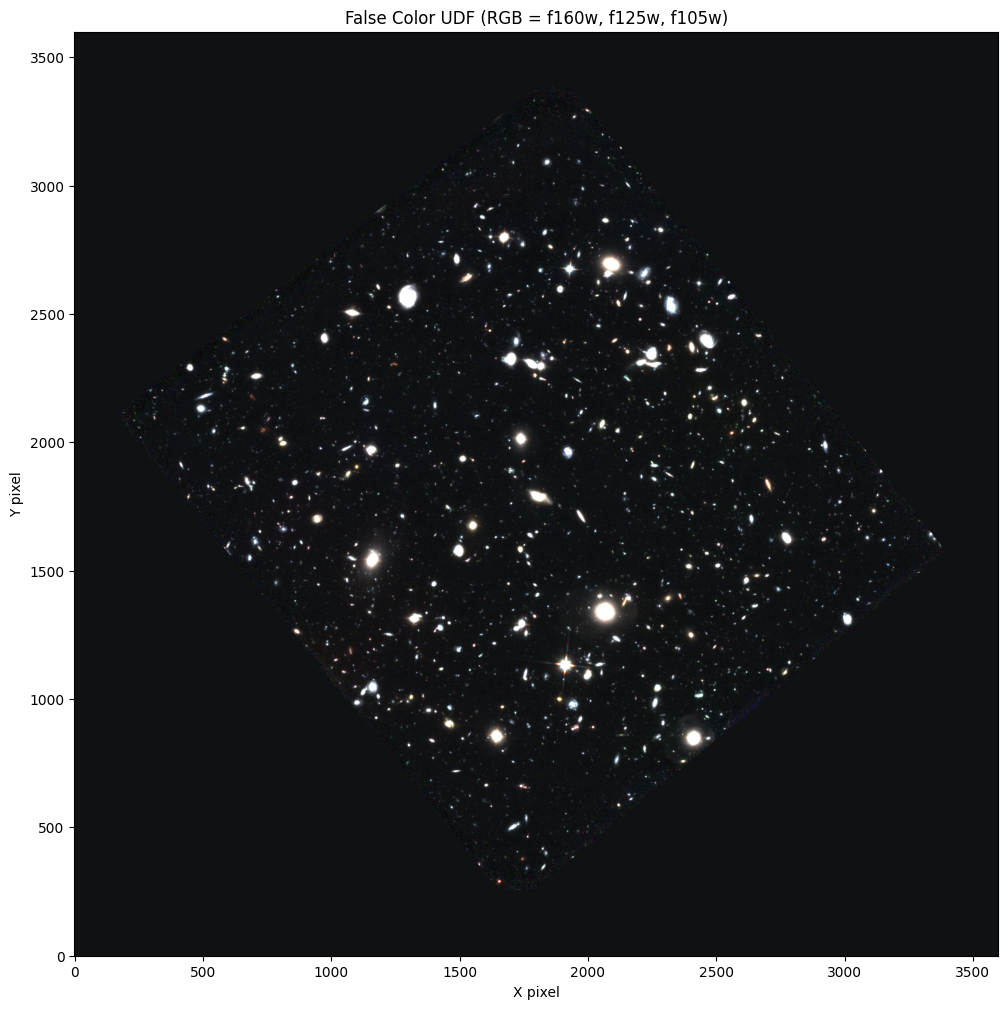

In [39]:
# --- STEP 8: MAKE FALSE COLOR IMAGE ---

# 1. Load the three different filters
# Red = f160w (Longest wavelength)
f160 = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")[0].data
# Green = f125w
f125 = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")[0].data
# Blue = f105w (Shortest wavelength)
f105 = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")[0].data

# 2. Re-orient data (byte-swap fix for all images, just in case)
f160 = f160.astype(float)
f125 = f125.astype(float)
f105 = f105.astype(float)

# 3. Create the RGB Stack
# Need array of shape (Height, Width, 3)
rgb = np.zeros((f160.shape[0], f160.shape[1], 3), dtype=float)

# 4. Normalization Helper Function
# Raw FITS data has a huge range. We use a log scale to see faint things.
def rescale_image(data):
    # Replace NaNs/Infinities with 0
    data[np.isnan(data)] = 0
    
    # Log scale: log(value + small_offset)
    # Small offset to avoid log(0)
    scaled = np.log10(data + 1.0) 
    
    # Normalize to 0-1 range based on min/max of the image
    # (Clip extremely bright pixels to avoid washing out the image)
    p_min = np.percentile(scaled, 0.25)
    p_max = np.percentile(scaled, 99.5) # Clip the top 0.5% brightest pixels
    
    return np.clip((scaled - p_min) / (p_max - p_min), 0, 1)

# Apply the scaling to each channel mapping
# Instruction: RGB -> f160w, f125w, f105w
rgb[:,:,0] = rescale_image(f160) # Red
rgb[:,:,1] = rescale_image(f125) # Green
rgb[:,:,2] = rescale_image(f105) # Blue

# 5. Plot and Save
plt.figure(figsize=(12, 12))
plt.imshow(rgb, origin='lower')
plt.title("False Color UDF (RGB = f160w, f125w, f105w)")
plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.savefig("UDF_5_rgb_false_color.png")
plt.show()